In [1]:
# Importing libraries

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Create a list with the filepaths for training and testing Videos/Project/RECIPE GENERATOR/Jupyter/split_refined_data
train_dir = Path('C:/Users/Lenovo/Videos/Project/RECIPE GENERATOR/Jupyter/split_refined_data/train')
train_filepaths = list(train_dir.glob('**/*.jpg'))

test_dir = Path('C:/Users/Lenovo/Videos/Project/RECIPE GENERATOR/Jupyter/split_refined_data/test')
test_filepaths = list(test_dir.glob('**/*.jpg'))

val_dir = Path('C:/Users/Lenovo/Videos/Project/RECIPE GENERATOR/Jupyter/split_refined_data/valid')
val_filepaths = list(val_dir.glob('**/*.jpg'))

In [3]:
def proc_img(filepaths):
    """Create a DataFrame with the filepath and the labels of the pictures"""
    
    if not filepaths:
        raise ValueError("No image files found in the specified directory.")
    
    labels = [os.path.basename(os.path.dirname(filepath)) for filepath in filepaths]
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})
    
    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


# Rest of your code remains unchanged
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [4]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 10326

Number of different labels: 26

Labels: ['LEMON' 'EGG' 'BEAN' 'CABBAGE' 'TURNIP' 'POTATO' 'CORN' 'PEAS'
 'CAULIFLOWER' 'BITTER GOURD' 'PUMPKIN' 'OKRA' 'LETTUCE' 'SPINACH'
 'TOMATO' 'BOTTLE GOURD' 'CHILLI' 'EGGPLANT' 'BEETROOT' 'GARLIC'
 'CAPSICUM' 'CARROT' 'ONION' 'GINGER' 'CUCUMBER' 'RADDISH']


In [5]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,C:\Users\Lenovo\Videos\Project\RECIPE GENERATO...,LEMON
1,C:\Users\Lenovo\Videos\Project\RECIPE GENERATO...,EGG
2,C:\Users\Lenovo\Videos\Project\RECIPE GENERATO...,LEMON
3,C:\Users\Lenovo\Videos\Project\RECIPE GENERATO...,BEAN
4,C:\Users\Lenovo\Videos\Project\RECIPE GENERATO...,CABBAGE


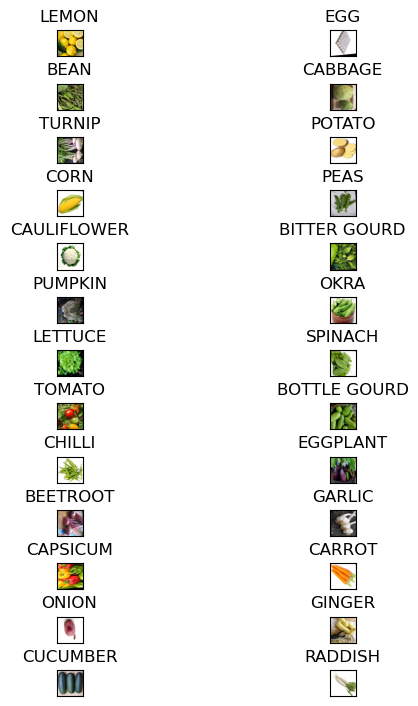

In [6]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index(drop=True)

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=13, ncols=2, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

# Determine the number of images to display
num_images = min(len(df_unique), 13 * 2)

for i, ax in enumerate(axes.flat[:num_images]):
    ax.imshow(plt.imread(df_unique.Filepath.iloc[i]))
    ax.set_title(df_unique.Label.iloc[i], fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Convert the 'Filepath' column to strings
train_df['Filepath'] = train_df['Filepath'].astype(str)
val_df['Filepath'] = val_df['Filepath'].astype(str)
test_df['Filepath'] = test_df['Filepath'].astype(str)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 10326 validated image filenames belonging to 26 classes.
Found 1300 validated image filenames belonging to 26 classes.
Found 1292 validated image filenames belonging to 26 classes.


In [8]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [9]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization

outputs = tf.keras.layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


323/323 ━━━━━━━━━━━━━━━━━━━━ 119s 329ms/step - accuracy: 0.1194 - loss: 3.1130 - val_accuracy: 0.7677 - val_loss: 1.0535
Epoch 2/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 102s 314ms/step - accuracy: 0.5192 - loss: 1.5888 - val_accuracy: 0.8815 - val_loss: 0.4811
Epoch 3/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 102s 314ms/step - accuracy: 0.6897 - loss: 0.9776 - val_accuracy: 0.9038 - val_loss: 0.3468
Epoch 4/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 103s 318ms/step - accuracy: 0.7689 - loss: 0.7460 - val_accuracy: 0.9200 - val_loss: 0.2938
Epoch 5/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 103s 318ms/step - accuracy: 0.8176 - loss: 0.6023 - val_accuracy: 0.9392 - val_loss: 0.2369
Epoch 6/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 102s 315ms/step - accuracy: 0.8421 - loss: 0.5187 - val_accuracy: 0.9423 - val_loss: 0.1999
Epoch 7/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 102s 313ms/step - accuracy: 0.8714 - loss: 0.4401 - val_accuracy: 0.9546 - val_loss: 0.1686
Epoch 8/20
323/323 ━━━━━━━━━━━━━━━━━━━━ 102s 315ms/step - accuracy: 0.8819 - loss: 0.40

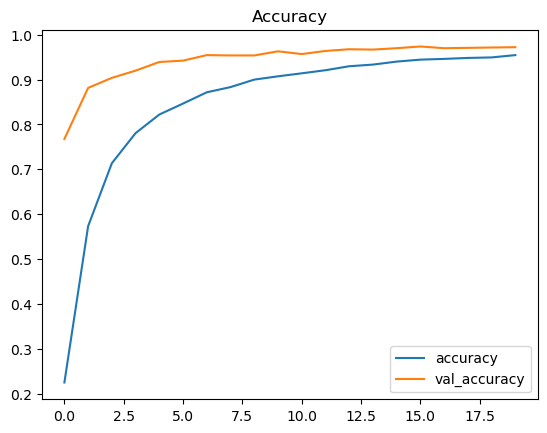

In [15]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

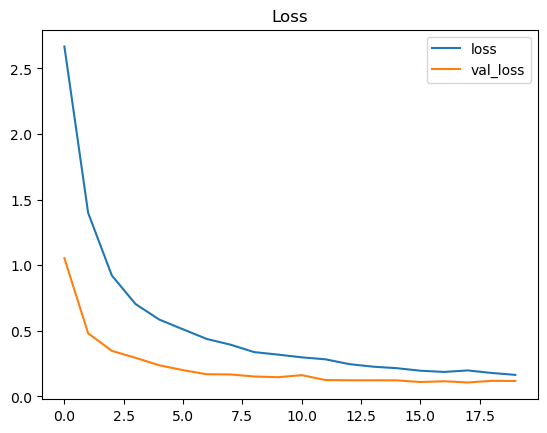

In [16]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 281ms/step


In [18]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 98.07%


In [14]:
model.save('mobileNet.keras')